# Evaluate CTGAN on eICU cardiorespiratory past history data

In [ ]:
#!pip install sdv

In [158]:
import os
import numpy as np
import pandas as pd
import sys
import ctgan
from ctgan import CTGANSynthesizer
#from ctgan import load_demo

# hide warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
os.getcwd()

In [ ]:
# create the reverse one hot encoded data
"""
# load the CTGAN demo data
data = pd.read_csv('examples\csv\patients_allpasthistory_onehot_cardiorespiratory.csv')
data.columns

os.chdir('../eICU_gan/dataprep')
#os.getcwd()

from create_eICU_data import reverse_one_hot

os.chdir('../../CTGAN_Distribution')
#os.getcwd()

new_df = reverse_one_hot(data, columns=['ethnicity_AfricanAmerican',
       'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_NativeAmerican', 'ethnicity_Other/Unknown'], prefix='ethnicity_', new_col='ethnicity')
#new_df.head()

new_df = reverse_one_hot(new_df, columns=['gender_Female','gender_Male'], prefix='gender_', new_col='gender')

new_df = reverse_one_hot(new_df, columns=['dischargestatus_Alive', 'dischargestatus_Expired'], prefix='dischargestatus_', new_col='dischargestatus')

#new_df.head()

print(new_df.columns)
# set the names of the demo data columns that are discrete

# save the eICU data without one hot encoded values so we can re-use it
new_df.to_csv('examples/csv/patients_cardiorespiratory_textcats.csv', index=False)
"""

In [2]:
new_df = pd.read_csv('examples/csv/patients_cardiorespiratory_textcats.csv')

In [ ]:
new_df.columns

In [308]:
new_df.shape

(2027, 15)

In [3]:
discrete_columns = [
    'CHF', 'COPD_moderate',
       'COPD_nolimitations', 'COPD_severe', 'NoHealthProblems', 'asthma',
       'homeoxygen', 'hypertensionrequiringtreatment',
       'restrictivepulmonarydisease', 'All', 'ethnicity', 'gender',
       'dischargestatus'
]

In [4]:
# create the dataframe format and csv file to save evaluations of the CTGAN
# columns will be number epoch, generator loss, discriminator loss, number of generated samples, 
# CSTest Value ours vs real, KSTest Value ours vs real, 
# CSTest Value real train/test, KSTest Value real train/test,
# MulticlassDecisionTreeClassifier for COPD_severe, MulticlassMLPClassifier for COPD_severe, 
# MulticlassDecisionTreeClassifier for CHF, MulticlassMLPClassifier for CHF
# MulticlassDecisionTreeClassifier for dischargestatus, MulticlassMLPClassifier for dischargestatus
# MulticlassDecisionTreeClassifier for COPD_severe, MulticlassMLPClassifier for COPD_severe - real train/test split, 
# MulticlassDecisionTreeClassifier for CHF, MulticlassMLPClassifier for CHF - real train/test split, 
# MulticlassDecisionTreeClassifier for dischargestatus, MulticlassMLPClassifier for dischargestatus - real train/test split, 

df_CTGAN_eval = pd.DataFrame(columns=['epochs', 'time', 'distributed', 'num_generated_samples', 
'CSTest_Value_ours_v_real', 'KSTest_Value_ours_v_real', 'CSTest_Value_real_train_test', 'KSTest_Value_real_train_test',
'COPD_severe_MulticlassDecisionTreeClassifier', 'COPD_severe_MulticlassMLPClassifier', 
'CHF_MulticlassDecisionTreeClassifier', 'CHF_MulticlassMLPClassifier', 
'NoHealthProblems_MulticlassDecisionTreeClassifier', 'NoHealthProblems_MulticlassMLPClassifier', 
'dischargestatus_MulticlassDecisionTreeClassifier', 'dischargestatus_MulticlassMLPClassifier',
'realsplit_COPD_severe_MulticlassDecisionTreeClassifier', 'realsplit_COPD_severe_MulticlassMLPClassifier',
'realsplit_CHF_MulticlassDecisionTreeClassifier', 'realsplit_CHF_MulticlassMLPClassifier', 
'realsplit_dischargestatus_MulticlassDecisionTreeClassifier', 'realsplit_dischargestatus_MulticlassMLPClassifier',
'realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier', 'realsplit_NoHealthProblems_MulticlassMLPClassifier'
])

# save the evaluation dataframe to a csv file
# LEAVE THIS COMMENTED OUT UNLESS YOU WANT TO OVERWRITE df_CTGAN_eval.to_csv('examples/csv/CTGAN_eval.csv', index=False)

#df_CTGAN_eval.head()

# load the evaluation dataframe from the csv file
df_CTGAN_eval = pd.read_csv('examples/csv/CTGAN_eval.csv')
print(df_CTGAN_eval.shape)
df_CTGAN_eval.head()

(0, 24)


,epochs,time,distributed,num_generated_samples,CSTest_Value_ours_v_real,KSTest_Value_ours_v_real,CSTest_Value_real_train_test,KSTest_Value_real_train_test,COPD_severe_MulticlassDecisionTreeClassifier,COPD_severe_MulticlassMLPClassifier,...,dischargestatus_MulticlassDecisionTreeClassifier,dischargestatus_MulticlassMLPClassifier,realsplit_COPD_severe_MulticlassDecisionTreeClassifier,realsplit_COPD_severe_MulticlassMLPClassifier,realsplit_CHF_MulticlassDecisionTreeClassifier,realsplit_CHF_MulticlassMLPClassifier,realsplit_dischargestatus_MulticlassDecisionTreeClassifier,realsplit_dischargestatus_MulticlassMLPClassifier,realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier,realsplit_NoHealthProblems_MulticlassMLPClassifier


In [5]:
import time
from sdv.evaluation import evaluate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sdv.metrics.tabular import MulticlassDecisionTreeClassifier, MulticlassMLPClassifier
from sklearn.model_selection import train_test_split

lst_num_epochs = [10,1000,5000,10000,15000,20000,25000]
#lst_num_epochs = [5]
lst_distributed = [True,False]
lst_num_samples = [2500,5000]

for e in lst_num_epochs:
    for dis in lst_distributed:
        for ns in lst_num_samples:

            print("===" * 30)
            print("num epochs: ", e)
            print("distributed: ", dis)
            print("num samples: ", ns)

            # initialze the CTGAN for 10 epochs, verbose, and both the generator and discriminator distributed
            ctgan = CTGANSynthesizer(epochs=e, verbose=False, distribute_g=dis, distribute_d=dis)

            # start the timer
            start_time = time.time()

            # fit the data == train CTGAN
            ctgan.fit(new_df, discrete_columns)

            end_time = time.time()
            total_time = end_time - start_time
            print("total_time: ", total_time)

            # gererate samples to evaluate the CTGAN
            samples = ctgan.sample(ns)
            
            # save the samples in case we want to work with them some more
            samples.to_csv('examples/csv/generated/CTGAN_e' + str(e) + '_dist' + str(dis) + '_numsamples' + str(ns) + '.csv', index=False)
            print('saved samples')

            # create a train/test split of the real data
            df_train, df_test = train_test_split(new_df, test_size=0.2, random_state=314)

            print(" ")
            print("Individual evaluation scores for real data train / test split: ")
            df_eval_real = evaluate(df_test, df_train, metrics=['CSTest', 'KSTest'], aggregate=False)
            real_CSTest_score = df_eval_real.query('metric == "CSTest"')['normalized_score'].values[0]
            real_KSTest_score = df_eval_real.query('metric == "KSTest"')['normalized_score'].values[0]
            print("real CSTest score: ", real_CSTest_score)
            print("real KSTest score: ", real_KSTest_score)
 
            print(" ")
            print("Individual evaluation scores for real data and CTGAN data: ")
            df_eval_ctgan = evaluate(new_df, samples, metrics=['CSTest', 'KSTest'], aggregate=False)

            ctgan_CSTest_score = df_eval_ctgan.query('metric == "CSTest"')['normalized_score'].values[0]
            ctgan_KSTest_score = df_eval_ctgan.query('metric == "KSTest"')['normalized_score'].values[0]

            print("CTGAN CSTest score: ", ctgan_CSTest_score)
            print("CTGAN KSTest score: ", ctgan_KSTest_score)

            # COPD severe evaluation
            treeclassifier_COPDsevere_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='COPD_severe')
            mlpclassifier_COPDsevere_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='COPD_severe')
            treeclassifier_COPDsevere_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='COPD_severe')
            mlpclassifier_COPDsevere_real = MulticlassMLPClassifier.compute(df_test, df_train, target='COPD_severe')

            #CHF evaluation
            treeclassifier_CHF_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='CHF')
            mlpclassifier_CHF_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='CHF')
            treeclassifier_CHF_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='CHF')
            mlpclassifier_CHF_real = MulticlassMLPClassifier.compute(df_test, df_train, target='CHF')

            # dischargestatus evaluation
            treeclassifier_dischargestatus_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='dischargestatus')
            mlpclassifier_dischargestatus_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='dischargestatus')
            treeclassifier_dischargestatus_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='dischargestatus')
            mlpclassifier_dischargestatus_real = MulticlassMLPClassifier.compute(df_test, df_train, target='dischargestatus')

            # NoHealthProblems evaluation
            treeclassifier_NoHealthProblems_ctgan = MulticlassDecisionTreeClassifier.compute(new_df, samples, target='NoHealthProblems')
            mlpclassifier_NoHealthProblems_ctgan = MulticlassMLPClassifier.compute(new_df, samples, target='NoHealthProblems')
            treeclassifier_NoHealthProblems_real = MulticlassDecisionTreeClassifier.compute(df_test, df_train, target='NoHealthProblems')
            mlpclassifier_NoHealthProblems_real = MulticlassMLPClassifier.compute(df_test, df_train, target='NoHealthProblems')

            df_CTGAN_eval.loc[len(df_CTGAN_eval.index)] = [e, total_time, dis,
            ns, ctgan_CSTest_score, 
            ctgan_KSTest_score, real_CSTest_score, 
            real_KSTest_score, 
            treeclassifier_COPDsevere_ctgan, 
            mlpclassifier_COPDsevere_ctgan, 
            treeclassifier_CHF_ctgan, mlpclassifier_CHF_ctgan,
            treeclassifier_NoHealthProblems_ctgan, 
            mlpclassifier_NoHealthProblems_ctgan,
            treeclassifier_dischargestatus_ctgan, 
            mlpclassifier_dischargestatus_ctgan,
            treeclassifier_COPDsevere_real, 
            mlpclassifier_COPDsevere_real, 
            treeclassifier_CHF_ctgan, mlpclassifier_CHF_real,
            treeclassifier_NoHealthProblems_real, 
            mlpclassifier_NoHealthProblems_real,
            treeclassifier_dischargestatus_real, 
            mlpclassifier_dischargestatus_real]


df_CTGAN_eval.to_csv('examples/csv/CTGAN_eval.csv', index=False)
df_CTGAN_eval.head()

        


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9_gsey_h because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


num epochs:  10
distributed:  True
num samples:  2500
total_time:  5.808379173278809
saved samples
 
Individual evaluation scores for real data train / test split: 
real CSTest score:  0.9601924543019867
real KSTest score:  0.9868813114813882
 
Individual evaluation scores for real data and CTGAN data: 
CTGAN CSTest score:  0.9784970277651888
CTGAN KSTest score:  0.9285212465055089
num epochs:  10
distributed:  True
num samples:  5000
total_time:  2.1010093688964844
saved samples
 
Individual evaluation scores for real data train / test split: 
real CSTest score:  0.9601924543019867
real KSTest score:  0.9868813114813882
 
Individual evaluation scores for real data and CTGAN data: 
CTGAN CSTest score:  0.9783053448128095
CTGAN KSTest score:  0.9357599736885381
num epochs:  10
distributed:  False
num samples:  2500
total_time:  2.3277177810668945
saved samples
 
Individual evaluation scores for real data train / test split: 
real CSTest score:  0.9601924543019867
real KSTest score:  0.9

,epochs,time,distributed,num_generated_samples,CSTest_Value_ours_v_real,KSTest_Value_ours_v_real,CSTest_Value_real_train_test,KSTest_Value_real_train_test,COPD_severe_MulticlassDecisionTreeClassifier,COPD_severe_MulticlassMLPClassifier,...,dischargestatus_MulticlassDecisionTreeClassifier,dischargestatus_MulticlassMLPClassifier,realsplit_COPD_severe_MulticlassDecisionTreeClassifier,realsplit_COPD_severe_MulticlassMLPClassifier,realsplit_CHF_MulticlassDecisionTreeClassifier,realsplit_CHF_MulticlassMLPClassifier,realsplit_dischargestatus_MulticlassDecisionTreeClassifier,realsplit_dischargestatus_MulticlassMLPClassifier,realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier,realsplit_NoHealthProblems_MulticlassMLPClassifier
0,10,5.808379,True,2500,0.978497,0.928521,0.960192,0.986881,0.490907,0.487614,...,0.490332,0.475278,0.594823,0.662332,0.487257,0.565737,0.975599,0.939772,0.544814,0.46789
1,10,2.101009,True,5000,0.978305,0.935760,0.960192,0.986881,0.505742,0.487614,...,0.503097,0.475278,0.591501,0.662332,0.501928,0.568085,0.975599,0.910018,0.550139,0.46789
2,10,2.327718,False,2500,0.976888,0.925635,0.960192,0.986881,0.493190,0.487614,...,0.497104,0.475278,0.594823,0.662332,0.488757,0.548012,0.975599,0.888594,0.558696,0.46789
3,10,2.242916,False,5000,0.976420,0.941926,0.960192,0.986881,0.511550,0.487614,...,0.508315,0.475278,0.591501,0.662332,0.481232,0.561193,0.975599,0.853729,0.566882,0.46789
4,1000,85.729557,True,2500,0.918522,0.919692,0.960192,0.986881,0.635315,0.723253,...,0.517245,0.480610,0.594823,0.662332,0.513085,0.548012,0.975599,0.920237,0.557819,0.46789


In [ ]:
df_CTGAN_eval.columns

In [ ]:
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['KSTest_Value_ours_v_real'], label='KSTest Value CTGAN v real')
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['CSTest_Value_ours_v_real'], c='orange', label='CSTest Value CTGAN v real')
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['KSTest_Value_real_train_test'], c='red', label='KSTest Value real train/test')
plt.scatter(df_CTGAN_eval['epochs'], df_CTGAN_eval['CSTest_Value_real_train_test'], c='green', label='CSTest Value real train/test')
plt.legend()

# Evaluation
* compare by number generated samples, because 2500 is similar to the number of samples used for training, BUT 5000 is twice that and we want to be able to generate larger amounts of data.
* There are **2** continuous variables that contribute to the KSTest value.
* There are **13** discrete values that contribute to the CSTest value.
    * Weighted evaluation:
        * abs(real_train_test(2 * KSTest) - CTGAN(2 * KSTest)) + abs(real_train_test(13 * KSTest) - CTGAN(13 * KSTest))
* There are the evaluations for machine learning efficacy for:
    * SUM of:
        * COPD_severe abs(real - CTGAN) for decisiontree and mlp classifiers
        * CHF abs(real - CTGAN) for decisiontree and mlp classifiers
        * dischargestatus abs(real - CTGAN) for decisiontree and mlp classifiers
        * NoHealthProblems abs(real - CTGAN) for decisiontree and mlp classifiers
    * individual performance
* time for distributed vs. not distributed by epoch

In [250]:
# retrieve evaluation file
df_CTGAN_eval = pd.read_csv('examples/csv/CTGAN_eval.csv')
df_CTGAN_eval = df_CTGAN_eval.query('epochs > 10')

#### real train/test 80/20 split == CS: 0.96 and KS: 0.987

#### at 20000 epochs we were able to generate 2500 samples with both CS and KS Test scores > 0.95 (CS: 0.955 and KS: 0.955)

#### at 25000 epochs we were able to generate 5000 samples with CS of 0.97 and KS of 0.949

In [251]:
# set limit for pandas dataframe column display to all
pd.set_option('display.max_columns', None)

df_CTGAN_eval.describe().loc['std']

epochs                                                         8478.446672
time                                                            641.335388
num_generated_samples                                          1276.884796
CSTest_Value_ours_v_real                                          0.029071
KSTest_Value_ours_v_real                                          0.010599
CSTest_Value_real_train_test                                      0.000000
KSTest_Value_real_train_test                                      0.000000
COPD_severe_MulticlassDecisionTreeClassifier                      0.028013
COPD_severe_MulticlassMLPClassifier                               0.034879
CHF_MulticlassDecisionTreeClassifier                              0.020981
CHF_MulticlassMLPClassifier                                       0.050482
NoHealthProblems_MulticlassDecisionTreeClassifier                 0.042201
NoHealthProblems_MulticlassMLPClassifier                          0.055797
dischargestatus_Multiclas

In [252]:
df_CTGAN_eval.describe().loc['mean']

epochs                                                         12666.666667
time                                                            1010.247628
num_generated_samples                                           3750.000000
CSTest_Value_ours_v_real                                           0.938793
KSTest_Value_ours_v_real                                           0.944836
CSTest_Value_real_train_test                                       0.960192
KSTest_Value_real_train_test                                       0.986881
COPD_severe_MulticlassDecisionTreeClassifier                       0.607852
COPD_severe_MulticlassMLPClassifier                                0.721178
CHF_MulticlassDecisionTreeClassifier                               0.563586
CHF_MulticlassMLPClassifier                                        0.562242
NoHealthProblems_MulticlassDecisionTreeClassifier                  0.911947
NoHealthProblems_MulticlassMLPClassifier                           0.939403
dischargesta

#### The most similar and with least variation is the CHF Decision Tree Classifier.



In [293]:
def plot_comparison_boxplots(df, col_prefix, feature_description):

    # boxplot for all columns
    # set the figure size
    plt.figure(figsize=(10, 4))
    df_eval = df[[col_prefix + '_MulticlassDecisionTreeClassifier','realsplit_' + col_prefix + '_MulticlassDecisionTreeClassifier', col_prefix + '_MulticlassMLPClassifier','realsplit_' + col_prefix + '_MulticlassMLPClassifier']]
    sns.boxplot(data=df_eval, palette="Set1")

    # set the x axis label text
    plt.xlabel('Classifier', fontdict={'fontsize': 14})
    # set the x axis tick labels
    plt.xticks(np.arange(0, 4), ('CTGAN DT', 'Real Data DT', 'CTGAN MLP', 'Real Data MLP'))
    # set font size of x tick labels
    plt.setp(plt.gca().get_xticklabels(), fontsize=12)

    plt.ylabel('Classifier Accuracy', fontdict={'fontsize': 14})

    plt.title('Compare CTGAN and real train/test: machine learning efficacy for ' + feature_description + ' classification', fontdict={'fontsize': 12
    })
    # save the plot to a file
    plt.savefig('eval_figs/' + col_prefix + '_boxplot.png')

    plt.show()

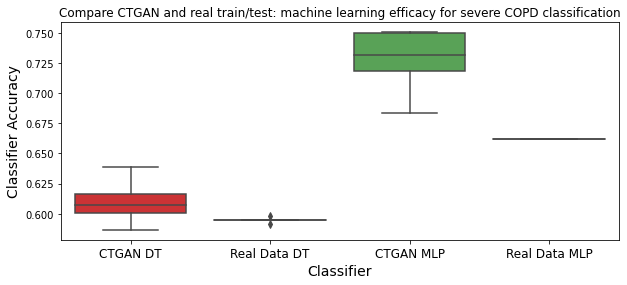

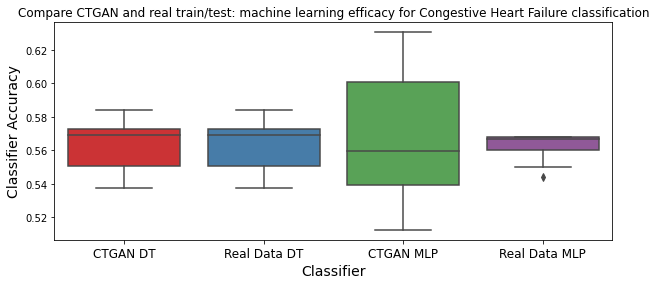

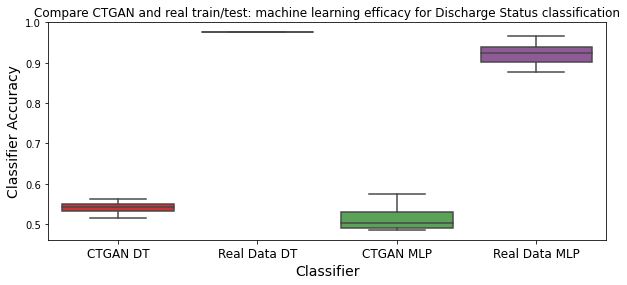

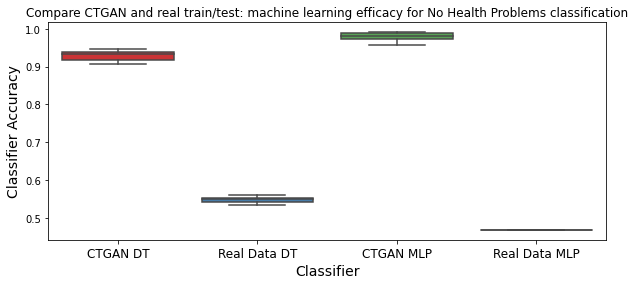

In [315]:
plot_comparison_boxplots(df_CTGAN_eval.query('num_generated_samples == 5000 and epochs > 9000'), 'COPD_severe', 'severe COPD')
plot_comparison_boxplots(df_CTGAN_eval.query('num_generated_samples == 5000 and epochs > 9000'), 'CHF', 'Congestive Heart Failure')
plot_comparison_boxplots(df_CTGAN_eval.query('num_generated_samples == 5000 and epochs > 9000'), 'dischargestatus', 'Discharge Status')
plot_comparison_boxplots(df_CTGAN_eval.query('num_generated_samples == 5000 and epochs > 9000'), 'NoHealthProblems', 'No Health Problems')


In [296]:
# sort by highest KSTest_Value_ours_v_real
df_CTGAN_eval.sort_values(by=['KSTest_Value_ours_v_real'], ascending=False, inplace=True)
df_CTGAN_eval.head()

,epochs,time,distributed,num_generated_samples,CSTest_Value_ours_v_real,KSTest_Value_ours_v_real,CSTest_Value_real_train_test,KSTest_Value_real_train_test,COPD_severe_MulticlassDecisionTreeClassifier,COPD_severe_MulticlassMLPClassifier,CHF_MulticlassDecisionTreeClassifier,CHF_MulticlassMLPClassifier,NoHealthProblems_MulticlassDecisionTreeClassifier,NoHealthProblems_MulticlassMLPClassifier,dischargestatus_MulticlassDecisionTreeClassifier,dischargestatus_MulticlassMLPClassifier,realsplit_COPD_severe_MulticlassDecisionTreeClassifier,realsplit_COPD_severe_MulticlassMLPClassifier,realsplit_CHF_MulticlassDecisionTreeClassifier,realsplit_CHF_MulticlassMLPClassifier,realsplit_dischargestatus_MulticlassDecisionTreeClassifier,realsplit_dischargestatus_MulticlassMLPClassifier,realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier,realsplit_NoHealthProblems_MulticlassMLPClassifier
13,10000,846.630173,True,5000,0.978079,0.967539,0.960192,0.986881,0.613450,0.750436,0.545916,0.512504,0.921822,0.982933,0.533059,0.490896,0.591501,0.662332,0.545916,0.568085,0.975599,0.910018,0.552023,0.46789
19,15000,1271.436891,False,5000,0.947099,0.959713,0.960192,0.986881,0.596270,0.683735,0.584305,0.601298,0.942823,0.987492,0.532458,0.574385,0.594823,0.662332,0.584305,0.568085,0.975599,0.877356,0.553930,0.46789
9,5000,420.282277,True,5000,0.885799,0.957809,0.960192,0.986881,0.555814,0.654532,0.586441,0.554254,0.883930,0.985891,0.502097,0.587190,0.598268,0.636753,0.586441,0.561193,0.975599,0.899476,0.541185,0.46789
20,20000,1564.890073,True,2500,0.955096,0.955350,0.960192,0.986881,0.623547,0.739155,0.586938,0.537702,0.959152,0.975112,0.519378,0.518568,0.598268,0.662332,0.586938,0.568085,0.975599,0.930151,0.562635,0.46789
24,25000,1893.838365,True,2500,0.928939,0.954927,0.960192,0.986881,0.572445,0.669244,0.600049,0.523929,0.938439,0.910246,0.536318,0.525871,0.594823,0.662332,0.600049,0.563441,0.975599,0.899476,0.544814,0.46789


In [336]:
def plot_value_by_epochs(df, num_samples_gen, test_column, test_description):

    # set the figure size
    plt.figure(figsize=(10, 4))
    df_eval = df.query('num_generated_samples == ' + num_samples_gen)
    sns.scatterplot(data=df_eval, x='epochs', hue='distributed', y=test_column, palette="Set1")
    sns.lineplot(data=df_eval, x='epochs', hue='distributed', y=test_column, palette="Set1")
    # set x axis ticks
    plt.xticks([1000,5000,10000,15000,20000,25000])

    # plot a dotted horizontal line at y = 0.95
    plt.axhline(y=0.95, color='k', linestyle='--', linewidth=1, label='95%')

    # set the x axis label text
    plt.xlabel('Epochs', fontdict={'fontsize': 14})

    plt.ylabel(test_description, fontdict={'fontsize': 14})

    plt.title(test_description + ' CTGAN to real data by epochs', fontdict={'fontsize': 14})
    #plt.legend()
    # save the plot to a file
    plt.savefig('eval_figs/' + test_column + '_' + str(num_samples_gen) + '_byepoch.png')

    plt.show()

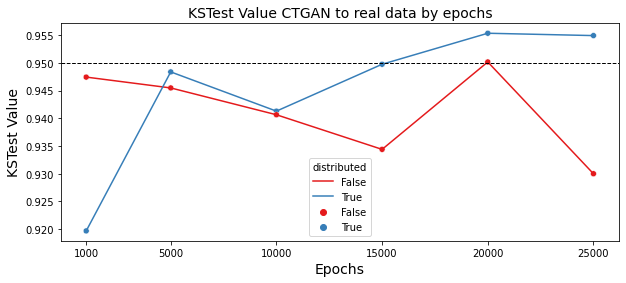

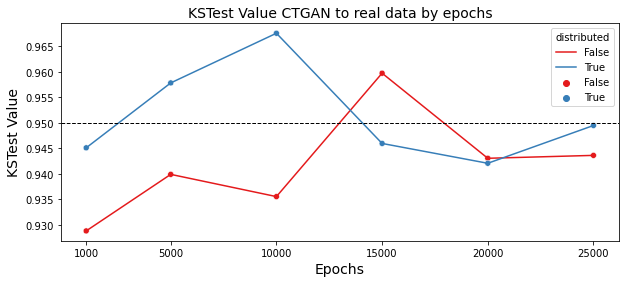

In [337]:
plot_value_by_epochs(df_CTGAN_eval, '2500', 'KSTest_Value_ours_v_real', 'KSTest Value')
plot_value_by_epochs(df_CTGAN_eval, '5000', 'KSTest_Value_ours_v_real', 'KSTest Value')

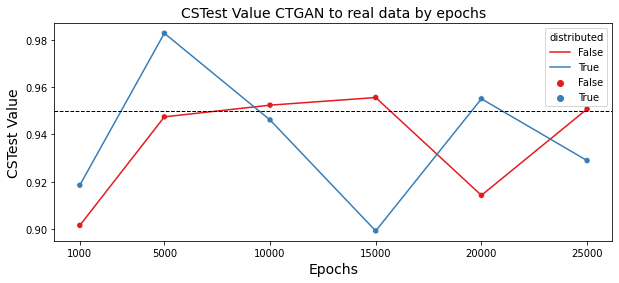

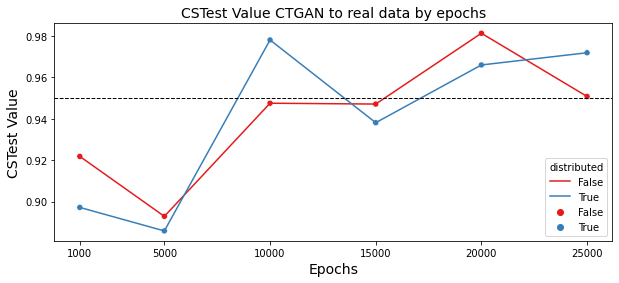

In [338]:
plot_value_by_epochs(df_CTGAN_eval, '2500', 'CSTest_Value_ours_v_real', 'CSTest Value')
plot_value_by_epochs(df_CTGAN_eval, '5000', 'CSTest_Value_ours_v_real', 'CSTest Value')

In [341]:
df_CTGAN_eval['KSTC'] = [1 - abs(1 - (g/r)) for g,r in zip(df_CTGAN_eval['KSTest_Value_ours_v_real'], df_CTGAN_eval['KSTest_Value_real_train_test'])]
df_CTGAN_eval['CSTC'] = [1 - abs(1 - (g/r)) for g,r in zip(df_CTGAN_eval['CSTest_Value_ours_v_real'], df_CTGAN_eval['CSTest_Value_real_train_test'])]

df_CTGAN_eval.to_csv('examples/csv/CTGAN_eval.csv', index=False)
df_CTGAN_eval.query('num_generated_samples == 5000 and epochs==25000')[['epochs','distributed','KSTC','KSTest_Value_ours_v_real','KSTest_Value_real_train_test','CSTC','CSTest_Value_ours_v_real','CSTest_Value_real_train_test']]

,epochs,distributed,KSTC,KSTest_Value_ours_v_real,KSTest_Value_real_train_test,CSTC,CSTest_Value_ours_v_real,CSTest_Value_real_train_test
25,25000,True,0.962087,0.949466,0.986881,0.987813,0.971894,0.960192
27,25000,False,0.956154,0.943611,0.986881,0.990183,0.950767,0.960192


## Plot time per number of epochs for single vs. multi GPU

In [353]:
df_CTGAN_eval['time_per_epoch'] = df_CTGAN_eval['time'] / df_CTGAN_eval['epochs']
df_CTGAN_eval.to_csv('examples/csv/CTGAN_eval.csv', index=False)

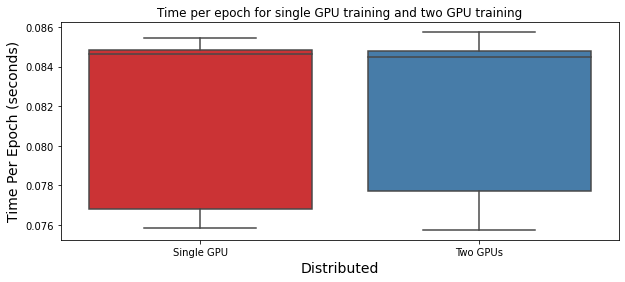

In [362]:
plt.figure(figsize=(10, 4))
df_eval = df_CTGAN_eval[['distributed','time_per_epoch']]
sns.boxplot(data=df_eval, x='distributed', y='time_per_epoch', palette="Set1")

# set the x axis label text
plt.xlabel('Distributed', fontdict={'fontsize': 14})
# set the x axis tick labels
plt.xticks(np.arange(0, 2), ('Single GPU', 'Two GPUs'))

# set font size of x tick labels
#plt.setp(plt.gca().get_xticklabels(), fontsize=12)

plt.ylabel('Time Per Epoch (seconds)', fontdict={'fontsize': 14})

plt.title('Time per epoch for single GPU training and two GPU training', fontdict={'fontsize': 12
})
# save the plot to a file
plt.savefig('eval_figs/NumGPUs_boxplot.png')

plt.show()

In [342]:
pd.set_option('display.max_columns', None)
df_CTGAN_eval

,epochs,time,distributed,num_generated_samples,CSTest_Value_ours_v_real,KSTest_Value_ours_v_real,CSTest_Value_real_train_test,KSTest_Value_real_train_test,COPD_severe_MulticlassDecisionTreeClassifier,COPD_severe_MulticlassMLPClassifier,CHF_MulticlassDecisionTreeClassifier,CHF_MulticlassMLPClassifier,NoHealthProblems_MulticlassDecisionTreeClassifier,NoHealthProblems_MulticlassMLPClassifier,dischargestatus_MulticlassDecisionTreeClassifier,dischargestatus_MulticlassMLPClassifier,realsplit_COPD_severe_MulticlassDecisionTreeClassifier,realsplit_COPD_severe_MulticlassMLPClassifier,realsplit_CHF_MulticlassDecisionTreeClassifier,realsplit_CHF_MulticlassMLPClassifier,realsplit_dischargestatus_MulticlassDecisionTreeClassifier,realsplit_dischargestatus_MulticlassMLPClassifier,realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier,realsplit_NoHealthProblems_MulticlassMLPClassifier,KSTC,CSTC
13,10000,846.630173,True,5000,0.978079,0.967539,0.960192,0.986881,0.613450,0.750436,0.545916,0.512504,0.921822,0.982933,0.533059,0.490896,0.591501,0.662332,0.545916,0.568085,0.975599,0.910018,0.552023,0.467890,0.980400,0.981372
19,15000,1271.436891,False,5000,0.947099,0.959713,0.960192,0.986881,0.596270,0.683735,0.584305,0.601298,0.942823,0.987492,0.532458,0.574385,0.594823,0.662332,0.584305,0.568085,0.975599,0.877356,0.553930,0.467890,0.972470,0.986364
9,5000,420.282277,True,5000,0.885799,0.957809,0.960192,0.986881,0.555814,0.654532,0.586441,0.554254,0.883930,0.985891,0.502097,0.587190,0.598268,0.636753,0.586441,0.561193,0.975599,0.899476,0.541185,0.467890,0.970541,0.922522
20,20000,1564.890073,True,2500,0.955096,0.955350,0.960192,0.986881,0.623547,0.739155,0.586938,0.537702,0.959152,0.975112,0.519378,0.518568,0.598268,0.662332,0.586938,0.568085,0.975599,0.930151,0.562635,0.467890,0.968050,0.994692
24,25000,1893.838365,True,2500,0.928939,0.954927,0.960192,0.986881,0.572445,0.669244,0.600049,0.523929,0.938439,0.910246,0.536318,0.525871,0.594823,0.662332,0.600049,0.563441,0.975599,0.899476,0.544814,0.467890,0.967621,0.967451
22,20000,1517.029792,False,2500,0.914225,0.950171,0.960192,0.986881,0.618483,0.742986,0.558006,0.574582,0.961409,0.977764,0.524582,0.490896,0.598268,0.662332,0.558006,0.565737,0.975599,0.930151,0.550139,0.467192,0.962802,0.952127
16,15000,1266.075081,True,2500,0.899163,0.949756,0.960192,0.986881,0.614378,0.730003,0.568099,0.522136,0.928607,0.838638,0.513509,0.581665,0.594823,0.662332,0.568099,0.563441,0.975599,0.920237,0.550139,0.467890,0.962382,0.936440
25,25000,1903.442145,True,5000,0.971894,0.949466,0.960192,0.986881,0.612524,0.749920,0.570793,0.553638,0.938279,0.957453,0.541103,0.510559,0.598268,0.662332,0.570793,0.568085,0.975599,0.939772,0.548277,0.467890,0.962087,0.987813
8,5000,423.939897,True,2500,0.982845,0.948377,0.960192,0.986881,0.618483,0.728241,0.572400,0.564580,0.835058,0.908096,0.518321,0.490896,0.594823,0.662332,0.572400,0.565737,0.975599,0.939772,0.542989,0.467890,0.960984,0.976408
6,1000,85.433408,False,2500,0.901503,0.947440,0.960192,0.986881,0.605575,0.723253,0.533818,0.483745,0.828658,0.773965,0.533210,0.475278,0.591501,0.662332,0.533818,0.565737,0.975599,0.877356,0.555862,0.467890,0.960034,0.938878


In [349]:
df_CTGAN_eval['CHF_MLEC_DT'] = [1 - abs(1 - (g/r)) for g,r in zip(df_CTGAN_eval['CHF_MulticlassDecisionTreeClassifier'], df_CTGAN_eval['realsplit_CHF_MulticlassDecisionTreeClassifier'])]
df_CTGAN_eval['CHF_MLEC_MLP'] = [1 - abs(1 - (g/r)) for g,r in zip(df_CTGAN_eval['CHF_MulticlassMLPClassifier'], df_CTGAN_eval['realsplit_CHF_MulticlassMLPClassifier'])]
df_CTGAN_eval['COPD_severe_MLEC_DT'] = [1 - abs(1 - (g/r)) for g,r in zip(df_CTGAN_eval['COPD_severe_MulticlassDecisionTreeClassifier'], df_CTGAN_eval['realsplit_COPD_severe_MulticlassDecisionTreeClassifier'])]
df_CTGAN_eval['COPD_severe_MLEC_MLP'] =             [1 - abs(1 - (g/r)) for g,r in zip(df_CTGAN_eval['COPD_severe_MulticlassMLPClassifier'], df_CTGAN_eval['realsplit_COPD_severe_MulticlassMLPClassifier'])]
df_CTGAN_eval['dischargestatus_severe_MLEC_DT'] =  [1 - abs(1 - (g/r)) for g,r in zip(df_CTGAN_eval['dischargestatus_MulticlassDecisionTreeClassifier'], df_CTGAN_eval['realsplit_dischargestatus_MulticlassDecisionTreeClassifier'])]
df_CTGAN_eval['dischargestatus_severe_MLEC_MLP'] = [1 - abs(1 - (g/r)) for g,r in zip(df_CTGAN_eval['dischargestatus_MulticlassMLPClassifier'], df_CTGAN_eval['realsplit_dischargestatus_MulticlassMLPClassifier'])]
df_CTGAN_eval['NoHealthProblems_MLEC_DT'] = [1 - abs(1 - (g/r)) for g,r in zip(df_CTGAN_eval['NoHealthProblems_MulticlassDecisionTreeClassifier'], df_CTGAN_eval['realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier'])]
df_CTGAN_eval['NoHealthProblems_MLEC_MLP'] = [1 - abs(1 - (g/r)) for g,r in zip(df_CTGAN_eval['NoHealthProblems_MulticlassMLPClassifier'], df_CTGAN_eval['realsplit_NoHealthProblems_MulticlassMLPClassifier'])]
df_CTGAN_eval.to_csv('examples/csv/CTGAN_eval.csv', index=False)
df_CTGAN_eval.query('epochs==25000 and num_generated_samples == 5000')

,epochs,time,distributed,num_generated_samples,CSTest_Value_ours_v_real,KSTest_Value_ours_v_real,CSTest_Value_real_train_test,KSTest_Value_real_train_test,COPD_severe_MulticlassDecisionTreeClassifier,COPD_severe_MulticlassMLPClassifier,CHF_MulticlassDecisionTreeClassifier,CHF_MulticlassMLPClassifier,NoHealthProblems_MulticlassDecisionTreeClassifier,NoHealthProblems_MulticlassMLPClassifier,dischargestatus_MulticlassDecisionTreeClassifier,dischargestatus_MulticlassMLPClassifier,realsplit_COPD_severe_MulticlassDecisionTreeClassifier,realsplit_COPD_severe_MulticlassMLPClassifier,realsplit_CHF_MulticlassDecisionTreeClassifier,realsplit_CHF_MulticlassMLPClassifier,realsplit_dischargestatus_MulticlassDecisionTreeClassifier,realsplit_dischargestatus_MulticlassMLPClassifier,realsplit_NoHealthProblems_MulticlassDecisionTreeClassifier,realsplit_NoHealthProblems_MulticlassMLPClassifier,KSTC,CSTC,CHF_MLEC_DT,CHF_MLEC_MLP,COPD_severe_MLEC_DT,COPD_severe_MLEC_MLP,dischargestatus_severe_MLEC_MLP,NoHealthProblems_MLEC_DT,NoHealthProblems_MLEC_MLP,dischargestatus_severe_MLEC_DT
25,25000,1903.442145,True,5000,0.971894,0.949466,0.960192,0.986881,0.612524,0.749920,0.570793,0.553638,0.938279,0.957453,0.541103,0.510559,0.598268,0.662332,0.570793,0.568085,0.975599,0.939772,0.548277,0.46789,0.962087,0.987813,1.0,0.974568,0.976172,0.867758,0.543280,0.288678,-0.046322,0.554637
27,25000,1907.304837,False,5000,0.950767,0.943611,0.960192,0.986881,0.601684,0.730002,0.570872,0.566044,0.930946,0.977764,0.545056,0.532585,0.594823,0.662332,0.570872,0.568085,0.975599,0.967016,0.560653,0.46789,0.956154,0.990183,1.0,0.996407,0.988464,0.897830,0.550751,0.339533,-0.089732,0.558689
